# Image Recognition


Consider at least three different types of objects in your environment (e.g., building, tree, car, etc. ) Then use your cellphone or any other camera you have to collect at least 100 different images of each category of object. Try to include diversity in the mages you collect. For instance, if car is one of the categories of object you chose, then don’t take 100 images of the same car, use a different car for each image. If you cannot find 100 different objects from the same category, then use Google images in addition to your cellphone to collect images.

Split the images you collected from each object into train/validation/ and test sets. Use the same directory structure as the one used in the lab. That is, create train, validation, and test folders where each folder contains different sub-folders for each category. Use 70% of images for training, 15% for validation and 15% for testing. Make sure the images in your train, test, and validation folders are not highly correlated. For instance, don’t include images of the same car in both train and validation or test set.

For this assignment, I'm using the CIFAR-10 dataset, which consists of 60,000 images across 10 classes: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck. I'm focusing on four specific categories: Cat, Bird, Horse, and Dog.

From each category, I've selected a total of 1,000 images. These images will be further split into training, validation, and test sets. The training set will comprise 700 images per category, while the validation and test sets will each contain 150 images per category.

In [ ]:
import os
import shutil
from keras.datasets import cifar10
from PIL import Image

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Specify the directory where we store smaller data
base_dir = 'cifar10_subset'

# Delete the directory if already exists
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

# Create subdirectories for train/test/validation under the base directory
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Categories to use from CIFAR-10
categories = ['cat', 'bird', 'horse', 'dog']

# Define the number of images per category for train, validation, and test
num_train_per_category = 700
num_val_per_category = 150
num_test_per_category = 150

# Define the actual class labels for CIFAR-10
cifar_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

for category in categories:
    # Create subdirectories for each category under train/validation/test directory
    train_category_dir = os.path.join(train_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    validation_category_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_category_dir, exist_ok=True)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(test_category_dir, exist_ok=True)

    # Indices of images in the current category (using the correct label index)
    indices = [i for i, label in enumerate(y_train) if label == cifar_class_names.index(category)]

    # Shuffle indices to randomize image selection
    import random
    random.shuffle(indices)

    # Select images for train, validation, and test
    train_indices = indices[:num_train_per_category]
    val_indices = indices[num_train_per_category:num_train_per_category + num_val_per_category]
    test_indices = indices[num_train_per_category + num_val_per_category:num_train_per_category + num_val_per_category + num_test_per_category]

    # Copy images to appropriate directories
    for idx_list, dest_dir in [(train_indices, train_category_dir),
                               (val_indices, validation_category_dir),
                               (test_indices, test_category_dir)]:
        for i, idx in enumerate(idx_list):
            img = x_train[idx]
            dst = os.path.join(dest_dir, f'{category}_{i}.jpg')

            # Convert to PIL Image and save
            img_pil = Image.fromarray(img)
            img_pil.save(dst)

# Print total number of images for each category and set
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    validation_category_dir = os.path.join(validation_dir, category)
    test_category_dir = os.path.join(test_dir, category)

    print(f'Total training {category} images:', len(os.listdir(train_category_dir)))
    print(f'Total validation {category} images:', len(os.listdir(validation_category_dir)))
    print(f'Total test {category} images:', len(os.listdir(test_category_dir)))

170498071/170498071 [==============================] - 13s 0us/step
Total training cat images: 700
Total validation cat images: 150
Total test cat images: 150
Total training bird images: 700
Total validation bird images: 150
Total test bird images: 150
Total training horse images: 700
Total validation horse images: 150
Total test horse images: 150
Total training dog images: 700
Total validation dog images: 150
Total test dog images: 150


In [ ]:
import tensorflow as tf


# Define image size and batch size
image_size = (32, 32)
batch_size = 32

# Create train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# Create validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# Create test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)


Found 2800 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Found 600 files belonging to 4 classes.


The goal is to train a CNN model to recognize the objects you chose in an image.

1. Create a baseline CNN model. **Make sure that you configure the loss, and the output layer correctly to represent a multi-class classification problem.** Plot the learning curves and answer the following questions:

**i.** What can you understand from the learning curves? Does your model overfit?

**ii.** If your model does not overfit, try increasing the capacity of your model by adding more convolutional layers, make sure that you increase the depth (number of channels as you add layers. Draw the learning curves again. How did adding more convolutional layers affected your training and validation accuracies? Does the new model overfit?

**iii.** Now replace convolutional layers with depth-wise separable convolution and add residual blocks. How did these changes affect your model performance?

**iv.** Add a couple of dense layers + dropout after the GAP (Global Average Pooling )layer and before the output layer. How did adding these layers affected your model performance in terms of training and validation losses.

**v.** Use data augmentation and retrain the model again from scratch. Does data augmentation improve the validation performance of your baseline model?

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers, Model


def build_baseline(input_shape, filters):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.experimental.preprocessing.Rescaling(1./255)(input)


  for filter in filters:
    #A block of one conv+batchnorm+relu  layers for extractign features
    x =layers.Conv2D(filters=filter, kernel_size=3, padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.ReLU()(x)

    #max pooling for downsampling
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

  #Global Average pooling. This will get an input of shape (height, width, channels) the average of each feature map and returns a vector of size channels.
  x = layers.GlobalAveragePooling2D()(x)

  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output = layers.Dense(4, activation="softmax")(x)
  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model

baseline=build_baseline(input_shape=(32,32,3), filters=[32,64,128, 256, 512])
print(baseline.summary())

# Compile the model
baseline.compile(optimizer='adam',  # Example optimizer
                 loss='sparse_categorical_crossentropy',  # Example loss function
                 metrics=['accuracy'])  # Example evaluation metric

# Train the model
history = baseline.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                          

**i.** What can you understand from the learning curves? Does your model overfit?

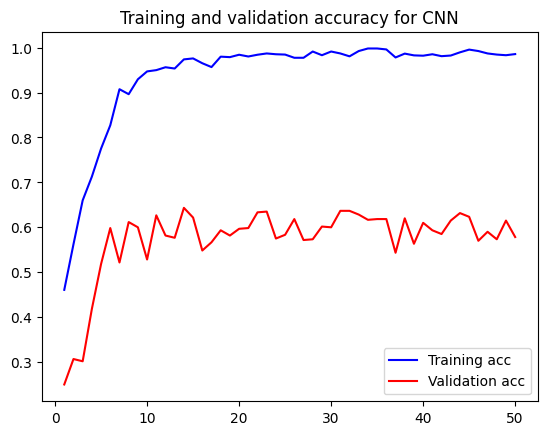

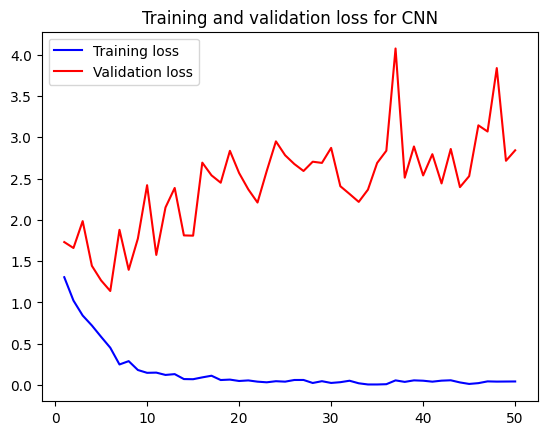

In [ ]:
import matplotlib.pyplot as plt

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

The model looks like overfit. Because model's accuracy on the training set is significantly high than its accuracy on the validation set. We can see the large gap between Training loss and validation loss. The validation loss reaches its minimum at epoch 8 and then bounces around whereas the training loss keeps decreasing as training proceeds.

**ii.** If your model does not overfit, try increasing the capacity of your model by adding more convolutional layers, make sure that you increase the depth (number of channels as you add layers. Draw the learning curves again. How did adding more convolutional layers affected your training and validation accuracies? Does the new model overfit?

In [ ]:
def build_high_capacity_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
# Build the high capacity model
high_capacity_model = build_high_capacity_model(input_shape=(32, 32, 3))

# Compile the model
high_capacity_model.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])


# Train the model
history_high_capacity = high_capacity_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1
)

Epoch 1/50
88/88 [==============================] - 3s 10ms/step - loss: 1.3786 - accuracy: 0.2868 - val_loss: 1.3432 - val_accuracy: 0.3883
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 1.2744 - accuracy: 0.4075 - val_loss: 1.1909 - val_accuracy: 0.4983
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 1.1471 - accuracy: 0.4704 - val_loss: 1.0910 - val_accuracy: 0.5250
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 1.0697 - accuracy: 0.5179 - val_loss: 1.1282 - val_accuracy: 0.4917
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.9951 - accuracy: 0.5636 - val_loss: 0.9550 - val_accuracy: 0.5683
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.8939 - accuracy: 0.6168 - val_loss: 1.0078 - val_accuracy: 0.5633
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.8250 - accuracy: 0.6450 - val_loss: 0.9059 - val_accuracy: 0.6033
Epoch 8/50
88/88 [=

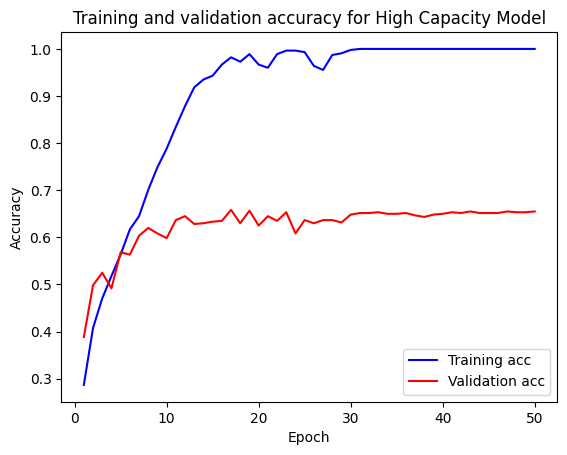

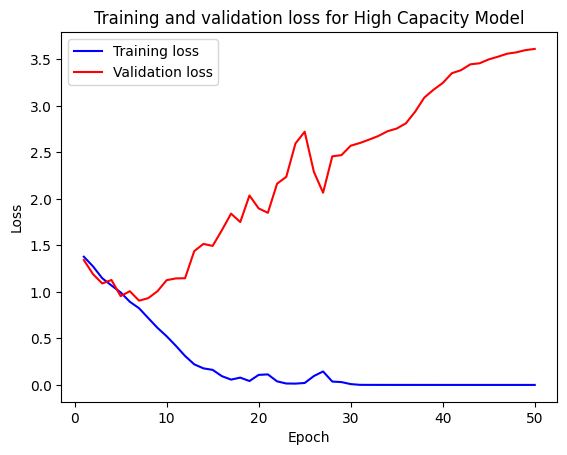

In [ ]:
# Getting train and validation accuracies
train_acc_high_capacity = history_high_capacity.history['accuracy']
val_acc_high_capacity = history_high_capacity.history['val_accuracy']

# Getting train and validation losses
train_loss_high_capacity = history_high_capacity.history['loss']
val_loss_high_capacity = history_high_capacity.history['val_loss']
epochs = range(1, len(train_loss_high_capacity) + 1)

# Plotting the training and validation accuracies
plt.plot(epochs, train_acc_high_capacity, 'b', label='Training acc')
plt.plot(epochs, val_acc_high_capacity, 'r', label='Validation acc')
plt.title('Training and validation accuracy for High Capacity Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

# Plotting the train and validation losses
plt.plot(epochs, train_loss_high_capacity, 'b', label='Training loss')
plt.plot(epochs, val_loss_high_capacity, 'r', label='Validation loss')
plt.title('Training and validation loss for High Capacity Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**iii.** Now replace convolutional layers with depth-wise separable convolution and add residual blocks. How did these changes affect your model performance?

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers, Model

def residual_block(x, filter):
    residual = x

    # x goes through a block consisting of two SeparableConv2D + BatchNormalization + ReLU
    x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsample the feature map by max pooling
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

    # Downsample residual and change its number of channels to "filter"
    residual = layers.Conv2D(filters=filter, kernel_size=1, strides=2, use_bias=False)(residual)

    # Add the downsampled residual to x
    x = layers.add([x, residual])
    return x

def build_model_with_depthwise_separable_and_resnet(input_shape, filters):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer for rescaling pixels to [0,1] range
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

    # The first layer is regular Conv2D layer because RGB channels are highly correlated
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Stack a set of residual blocks
    for filter in filters:
        x = residual_block(x, filter)

    # The final output layer has 4 neurons with softmax activation for multi-class classification
    output = layers.Dense(4, activation="softmax")(x)

    # Create a model and set its input and output and return it
    model = keras.Model(inputs=inputs, outputs=output)
    return model

# Build the model
build_model_with_depthwise_separable_and_resnet = build_model_with_depthwise_separable_and_resnet(input_shape=(32, 32, 3), filters=[32, 64, 128, 256, 512])
print(build_model_with_depthwise_separable_and_resnet.summary())



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 32)           2400      ['rescaling_2[0][0]']         
                                                                                                  
 batch_normalization_5 (Bat  (None, 32, 32, 32)           128       ['conv2d_10[0][0]']           
 chNormalization)                                                                           

In [ ]:

# Compile the model
build_model_with_depthwise_separable_and_resnet.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])

# Train the model
history_depthwise_resnet = build_model_with_depthwise_separable_and_resnet.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset)


Epoch 1/50
88/88 [==============================] - 11s 29ms/step - loss: 1.8839 - accuracy: 0.2530 - val_loss: 1.3879 - val_accuracy: 0.2486
Epoch 2/50
88/88 [==============================] - 1s 12ms/step - loss: 1.2234 - accuracy: 0.2525 - val_loss: 1.3858 - val_accuracy: 0.2511
Epoch 3/50
88/88 [==============================] - 1s 12ms/step - loss: 1.0444 - accuracy: 0.2543 - val_loss: 1.3906 - val_accuracy: 0.2503
Epoch 4/50
88/88 [==============================] - 1s 12ms/step - loss: 0.8474 - accuracy: 0.2556 - val_loss: 1.4197 - val_accuracy: 0.2500
Epoch 5/50
88/88 [==============================] - 1s 12ms/step - loss: 0.7018 - accuracy: 0.2627 - val_loss: 1.3271 - val_accuracy: 0.2532
Epoch 6/50
88/88 [==============================] - 1s 12ms/step - loss: 0.4892 - accuracy: 0.2626 - val_loss: 1.2477 - val_accuracy: 0.2569
Epoch 7/50
88/88 [==============================] - 1s 12ms/step - loss: 0.3638 - accuracy: 0.2650 - val_loss: 1.3004 - val_accuracy: 0.2524
Epoch 8/50
8

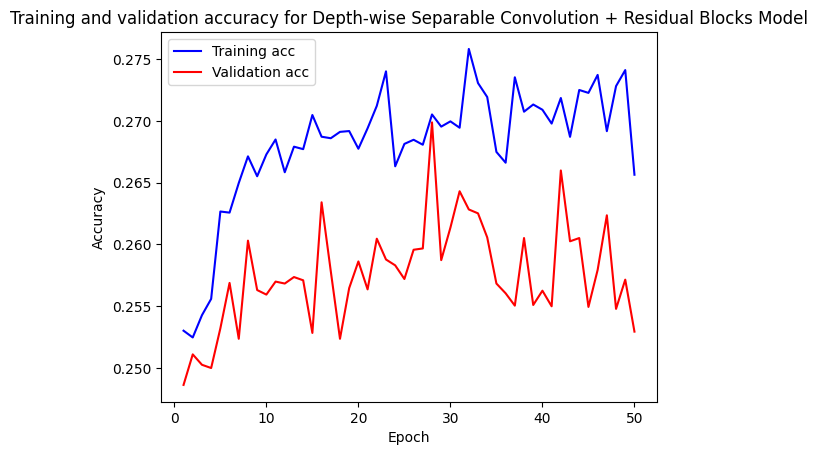

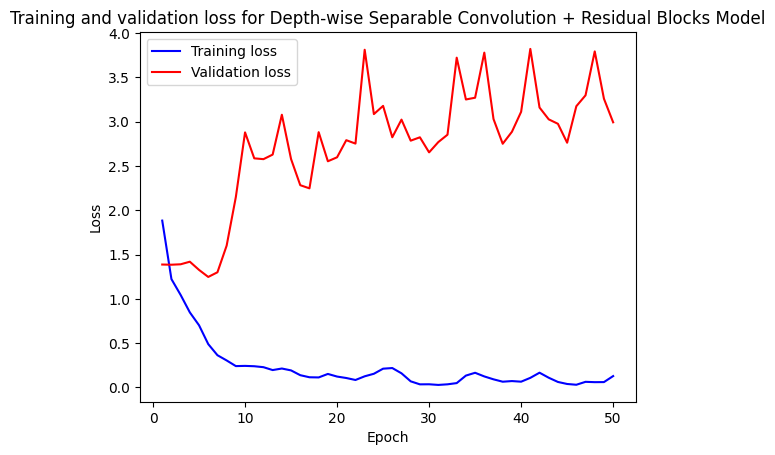

In [ ]:
# import matplotlib.pyplot as plt

# Getting train and validation accuracies
train_acc_depthwise_resnet = history_depthwise_resnet.history['accuracy']
val_acc_depthwise_resnet = history_depthwise_resnet.history['val_accuracy']

# Getting train and validation losses
train_loss_depthwise_resnet = history_depthwise_resnet.history['loss']
val_loss_depthwise_resnet = history_depthwise_resnet.history['val_loss']
epochs = range(1, len(train_loss_depthwise_resnet) + 1)

# Plotting the training and validation accuracies
plt.plot(epochs, train_acc_depthwise_resnet, 'b', label='Training acc')
plt.plot(epochs, val_acc_depthwise_resnet, 'r', label='Validation acc')
plt.title('Training and validation accuracy for Depth-wise Separable Convolution + Residual Blocks Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plt.figure()

# Plotting the train and validation losses
plt.plot(epochs, train_loss_depthwise_resnet, 'b', label='Training loss')
plt.plot(epochs, val_loss_depthwise_resnet, 'r', label='Validation loss')
plt.title('Training and validation loss for Depth-wise Separable Convolution + Residual Blocks Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The training accuracy is significantly decreasing. This shows under fitting. Training loss curve is decraesing slowly over epocs but validation shows more fluctuations.

**iv.** Add a couple of dense layers + dropout after the GAP (Global Average Pooling )layer and before the output layer. How did adding these layers affected your model performance in terms of training and validation losses.

In [ ]:
from tensorflow.keras.layers import Dropout, Dense

def build_model_with_dense_layers(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Depth-wise separable convolution and residual blocks
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    num_res_blocks = 3
    for _ in range(num_res_blocks):
        x = residual_block(x, 32)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers and dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



In [ ]:
# Build the model
model_with_dense_layers = build_model_with_dense_layers(input_shape=(32, 32, 3))

# Compile the model
model_with_dense_layers.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

# Train the model
history_with_dense_layers = model_with_dense_layers.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
88/88 [==============================] - 8s 18ms/step - loss: 1.5324 - accuracy: 0.2768 - val_loss: 1.3998 - val_accuracy: 0.2500
Epoch 2/50
88/88 [==============================] - 1s 9ms/step - loss: 1.3753 - accuracy: 0.3204 - val_loss: 1.3762 - val_accuracy: 0.2950
Epoch 3/50
88/88 [==============================] - 1s 9ms/step - loss: 1.3198 - accuracy: 0.3711 - val_loss: 1.3402 - val_accuracy: 0.3733
Epoch 4/50
88/88 [==============================] - 1s 9ms/step - loss: 1.2623 - accuracy: 0.4354 - val_loss: 1.2765 - val_accuracy: 0.4100
Epoch 5/50
88/88 [==============================] - 1s 9ms/step - loss: 1.2133 - accuracy: 0.4557 - val_loss: 1.1824 - val_accuracy: 0.4517
Epoch 6/50
88/88 [==============================] - 1s 9ms/step - loss: 1.1801 - accuracy: 0.4654 - val_loss: 1.2485 - val_accuracy: 0.4283
Epoch 7/50
88/88 [==============================] - 1s 9ms/step - loss: 1.1254 - accuracy: 0.5021 - val_loss: 1.1218 - val_accuracy: 0.4967
Epoch 8/50
88/88 [=

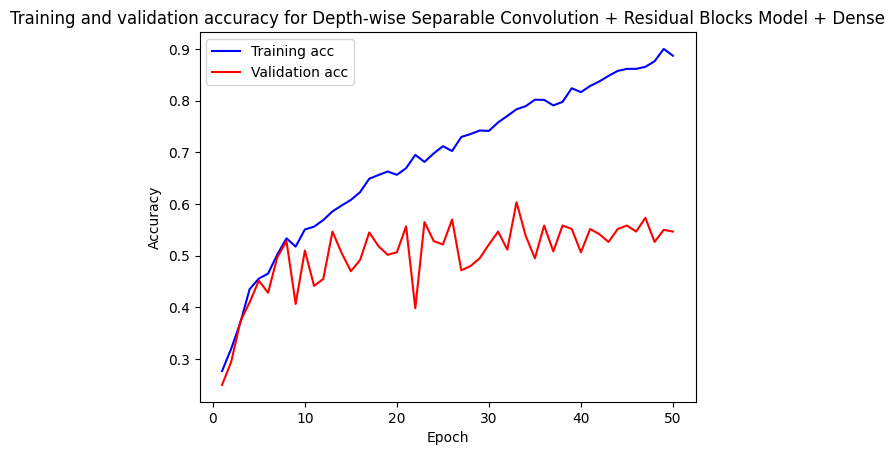

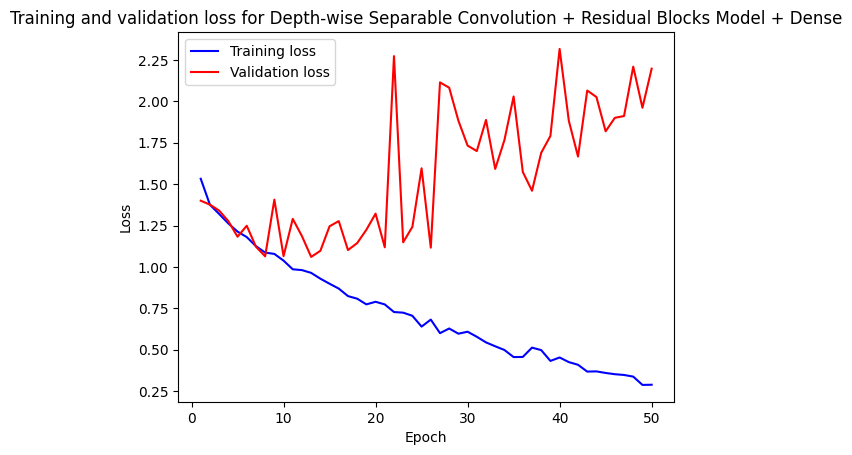

In [ ]:
# Getting train and validation accuracies
train_acc_dense_layers = history_with_dense_layers.history['accuracy']
val_acc_dense_layers = history_with_dense_layers.history['val_accuracy']

# Getting train and validation losses
train_loss_dense_layers = history_with_dense_layers.history['loss']
val_loss_dense_layers = history_with_dense_layers.history['val_loss']
epochs = range(1, len(train_loss_dense_layers) + 1)

# Plotting the training and validation accuracies
plt.plot(epochs, train_acc_dense_layers, 'b', label='Training acc')
plt.plot(epochs, val_acc_dense_layers, 'r', label='Validation acc')
plt.title('Training and validation accuracy for Depth-wise Separable Convolution + Residual Blocks Model + Dense')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

# Plotting the train and validation losses
plt.plot(epochs, train_loss_dense_layers, 'b', label='Training loss')
plt.plot(epochs, val_loss_dense_layers, 'r', label='Validation loss')
plt.title('Training and validation loss for Depth-wise Separable Convolution + Residual Blocks Model + Dense')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Our results show that dense layers with dropout outperform depth-wise separable convolutions in this specific case. While the validation accuracy has improved, we observed a narrowing gap between training and validation loss after a few epochs. This suggests potential overfitting. However, the model's performance remains the best among the architectures we have evaluated so far. Further investigation into regularization techniques may be beneficial to address potential overfitting concerns.

**v.** Use data augmentation and retrain the model again from scratch. Does data augmentation improve the validation performance of your baseline model?

In [ ]:

# Define data augmentation function
def data_augmentation(x):
    x = layers.experimental.preprocessing.RandomFlip("horizontal")(x)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.2)(x)
    return x

# Build the model with dense layers, dropout, depth-wise separable convolution, and residual blocks
def build_model_with_dense_layers_agu(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)  # Apply data augmentation

    # Depth-wise separable convolution
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual blocks
    num_res_blocks = 3
    for _ in range(num_res_blocks):
        x = residual_block(x, 32)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers with dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(4, activation='softmax')(x)  # Assuming 4 classes

    model = Model(inputs, outputs)
    return model




In [ ]:
# Build the model
model_agu_dense_layers = build_model_with_dense_layers_agu(input_shape=(32, 32, 3))

# Compile the model
model_agu_dense_layers.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

# Train the model
history_with_dense_layers_agu = model_agu_dense_layers.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)

Epoch 1/50
88/88 [==============================] - 7s 14ms/step - loss: 1.5078 - accuracy: 0.2750 - val_loss: 1.4327 - val_accuracy: 0.2517
Epoch 2/50
88/88 [==============================] - 1s 10ms/step - loss: 1.3827 - accuracy: 0.3039 - val_loss: 1.4147 - val_accuracy: 0.2600
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 1.3405 - accuracy: 0.3411 - val_loss: 1.3838 - val_accuracy: 0.2867
Epoch 4/50
88/88 [==============================] - 1s 11ms/step - loss: 1.3129 - accuracy: 0.3696 - val_loss: 1.3083 - val_accuracy: 0.3900
Epoch 5/50
88/88 [==============================] - 1s 11ms/step - loss: 1.2888 - accuracy: 0.3996 - val_loss: 1.3331 - val_accuracy: 0.3550
Epoch 6/50
88/88 [==============================] - 1s 10ms/step - loss: 1.2657 - accuracy: 0.4157 - val_loss: 1.2711 - val_accuracy: 0.4267
Epoch 7/50
88/88 [==============================] - 1s 11ms/step - loss: 1.2312 - accuracy: 0.4350 - val_loss: 1.3317 - val_accuracy: 0.3883
Epoch 8/50
88

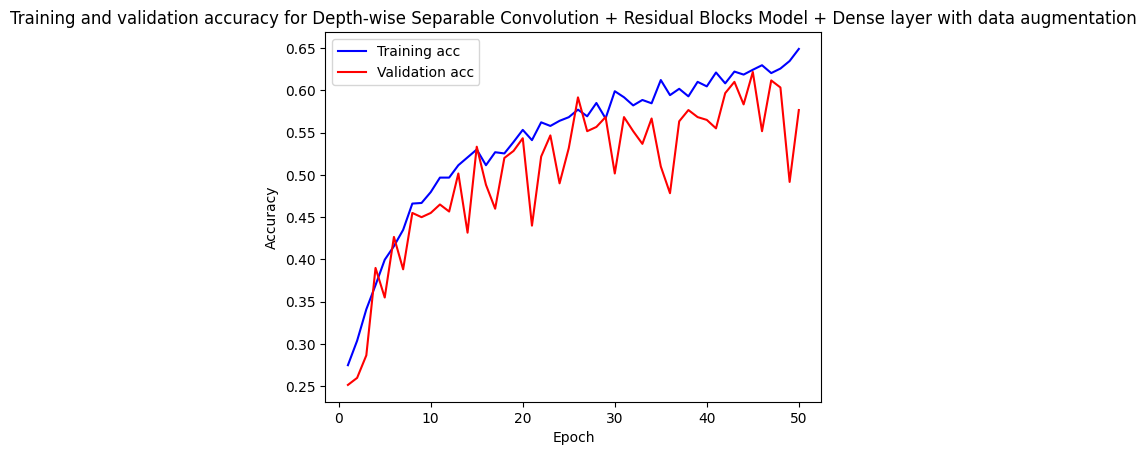

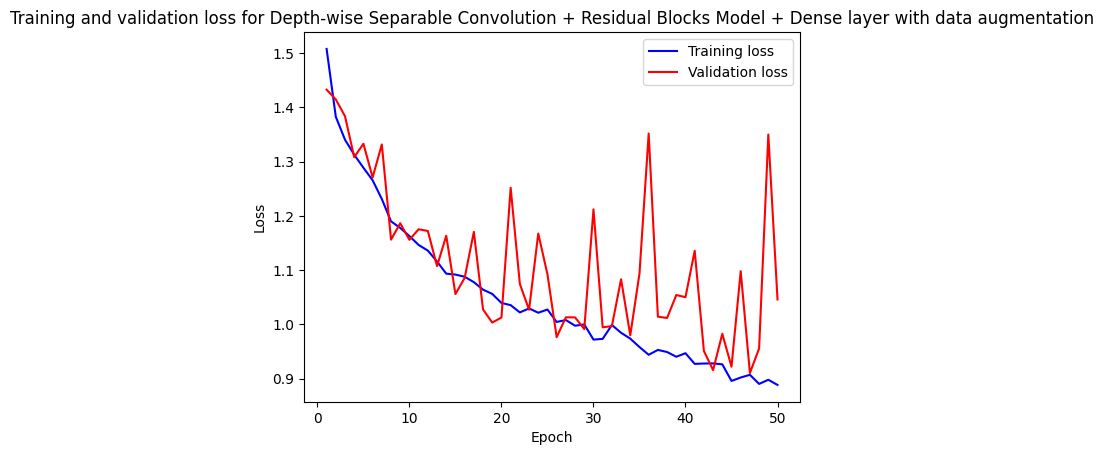

In [ ]:
# Getting train and validation accuracies
train_acc_dense_layers_agu = history_with_dense_layers_agu.history['accuracy']
val_acc_dense_layers_agu = history_with_dense_layers_agu.history['val_accuracy']

# Getting train and validation losses
train_loss_dense_layers_agu = history_with_dense_layers_agu.history['loss']
val_loss_dense_layers_agu = history_with_dense_layers_agu.history['val_loss']
epochs = range(1, len(train_loss_dense_layers_agu) + 1)

# Plotting the training and validation accuracies
plt.plot(epochs, train_acc_dense_layers_agu, 'b', label='Training acc')
plt.plot(epochs, val_acc_dense_layers_agu, 'r', label='Validation acc')
plt.title('Training and validation accuracy for Depth-wise Separable Convolution + Residual Blocks Model + Dense layer with data augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

# Plotting the train and validation losses
plt.plot(epochs, train_loss_dense_layers_agu, 'b', label='Training loss')
plt.plot(epochs, val_loss_dense_layers_agu, 'r', label='Validation loss')
plt.title('Training and validation loss for Depth-wise Separable Convolution + Residual Blocks Model + Dense layer with data augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The data augmentation seems to be effective for this model. While the training and validation accuracy are similar, and the loss curves show a gradual decrease, it's essential to further investigate potential overfitting.

**** Use a known model architecture such as VGG, DenseNet, MobileNet, or ResNet pertained on ImageNet and do both feature extraction and fine-tuning on your dataset (fine tune the last convolutional block only). Does transfer learning increase your validation accuracy?
Try to improve your model by tuning learning rate and the number of residual blocks to see how that affects the validation performance)

I use  DenseNet121, first I will do Feature Extraction, once the Feature Extraction completed will di fine tuning on last layer.

In [ ]:
#instantiate a DenseNet121 model trained on ImageNet dataset
from tensorflow.keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

#freeze the weight of the convolutional base
conv_base.trainable=False

# get the summary of the model to view its architecture
conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 38, 38, 3)            0         ['input_7[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 16, 64)           9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1/conv[0][0]']

In [ ]:
# Define data augmentation function
def data_augmentation_2(x):
    layers.experimental.preprocessing.RandomFlip('horizontal')(x),
    layers.experimental.preprocessing.RandomRotation(0.2)(x),
    layers.experimental.preprocessing.RandomZoom(0.2)(x),
    layers.experimental.preprocessing.RandomContrast(0.2)(x)
    return x

# def residual_block_2(x, filter):
#     residual = x

#     # x goes through a block consisting of two SeparableConv2D + BatchNormalization + ReLU
#     x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.SeparableConv2D(filters=filter, kernel_size=3, padding="same", use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # Downsample the feature map by max pooling
#     x = layers.MaxPooling2D(pool_size=2, padding="same")(x)

#     # Downsample residual and change its number of channels to "filter"
#     residual = layers.Conv2D(filters=filter, kernel_size=1, strides=2, use_bias=False)(residual)

#     # Add the downsampled residual to x
#     x = layers.add([x, residual])
#     return x


def build_pretrained(input_shape):

  #Configuring the model architecture

  #input layer for getting the input image
  input = keras.Input(shape=input_shape)

  #Add the data_augmentation layers here:
  x=data_augmentation_2(input)

  #rescaling layer for rescalign pixels to [0,1] range
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)

  #Using the pre-trained conv_base
  x = conv_base(x)


  # Global Average Pooling
  x = layers.GlobalAveragePooling2D()(x)


  #The final output layer has one neuron with sigmoid activation to output the probability of the target class ( cate or dog whichever is labled as one)
  output=layers.Dense(4, activation="softmax")(x)

  #create a model and set its input and output and return it
  model = keras.Model(inputs=input, outputs=output)
  return model

pretrained_model=build_pretrained(input_shape=(32,32,3))
print(pretrained_model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 7041604 (26.86 MB)
Trainable params: 4100 (16.02 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________

In [ ]:
#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
pretrained_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)


history_pretrained_model = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1
            )

Epoch 1/50
88/88 [==============================] - 9s 36ms/step - loss: 0.5932 - accuracy: 0.7736 - val_loss: 0.8974 - val_accuracy: 0.6183
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5919 - accuracy: 0.7732 - val_loss: 0.8974 - val_accuracy: 0.6233
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5908 - accuracy: 0.7743 - val_loss: 0.8992 - val_accuracy: 0.6183
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5899 - accuracy: 0.7725 - val_loss: 0.8985 - val_accuracy: 0.6200
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5886 - accuracy: 0.7743 - val_loss: 0.8999 - val_accuracy: 0.6167
Epoch 6/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5890 - accuracy: 0.7725 - val_loss: 0.9007 - val_accuracy: 0.6167
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5878 - accuracy: 0.7736 - val_loss: 0.9000 - val_accuracy: 0.6217
Epoch 8/50
88

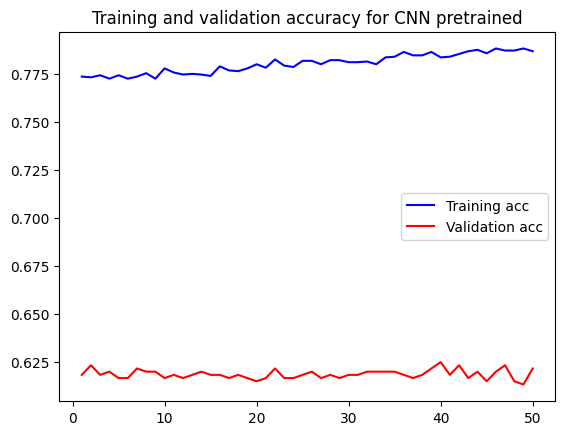

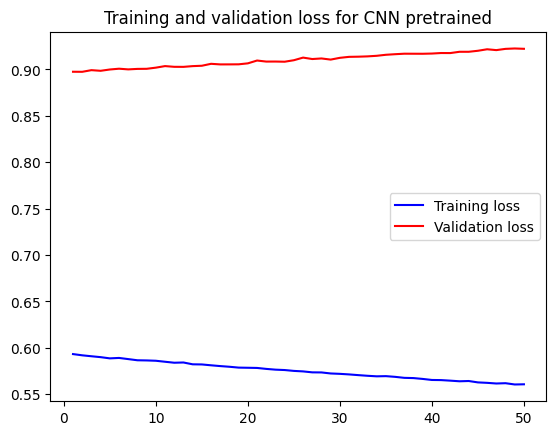

In [ ]:
#getting train and validation accuracies
train_acc_history_pretrained = history_pretrained_model.history['accuracy']
val_acc_history_pretrained = history_pretrained_model.history['val_accuracy']

#getting train and validation losses
train_loss_history_pretrained = history_pretrained_model.history['loss']
val_loss_history_pretrained = history_pretrained_model.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_history_pretrained, 'b', label='Training acc')
plt.plot(epochs, val_acc_history_pretrained, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN pretrained')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_history_pretrained, 'b', label='Training loss')
plt.plot(epochs, val_loss_history_pretrained, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN pretrained')
plt.legend()

plt.show()

# Fine Tuning

In [ ]:
#unfreez the convolution base
conv_base.trainable = True

#set trainable to False for all layers except the last 9 , that is freeze the weights for all layers except the last 9 layers
for layer in conv_base.layers[:-9]:
    layer.trainable=False

#set trainable to True for the convolutional layhers in the last 9 layers ( the last convolutional block in DENSENET121).
for layer in conv_base.layers[-9:]:
    # we only want to unfreez the convolutional layers (batch normalizataion layers remain frozen)
    if layer.name.endswith("conv"):
      layer.trainable=True

print(pretrained_model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 7041604 (26.86 MB)
Trainable params: 172228 (672.77 KB)
Non-trainable params: 6869376 (26.20 MB)
______________

In [ ]:
#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
pretrained_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)


history_fine_tune = pretrained_model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = 50,
            verbose = 1
            )

Epoch 1/50
88/88 [==============================] - 11s 38ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 2.9150 - val_accuracy: 0.6100
Epoch 2/50
88/88 [==============================] - 1s 16ms/step - loss: 0.0476 - accuracy: 0.9818 - val_loss: 2.8526 - val_accuracy: 0.6183
Epoch 3/50
88/88 [==============================] - 1s 16ms/step - loss: 0.0443 - accuracy: 0.9846 - val_loss: 2.8411 - val_accuracy: 0.6250
Epoch 4/50
88/88 [==============================] - 2s 17ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 2.7853 - val_accuracy: 0.6233
Epoch 5/50
88/88 [==============================] - 1s 16ms/step - loss: 0.0257 - accuracy: 0.9889 - val_loss: 2.8054 - val_accuracy: 0.6167
Epoch 6/50
88/88 [==============================] - 1s 16ms/step - loss: 0.0187 - accuracy: 0.9932 - val_loss: 2.8179 - val_accuracy: 0.6083
Epoch 7/50
88/88 [==============================] - 1s 17ms/step - loss: 0.0283 - accuracy: 0.9889 - val_loss: 2.8039 - val_accuracy: 0.6133
Epoch 8/50
8

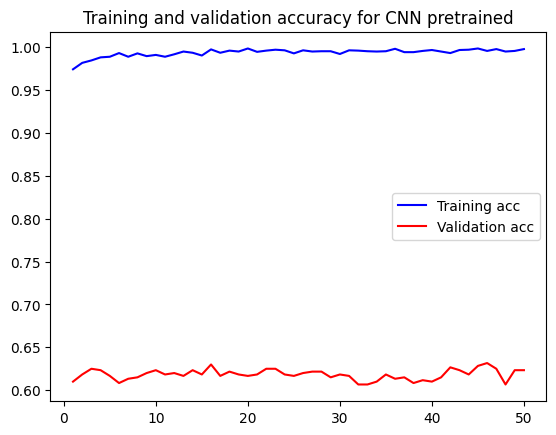

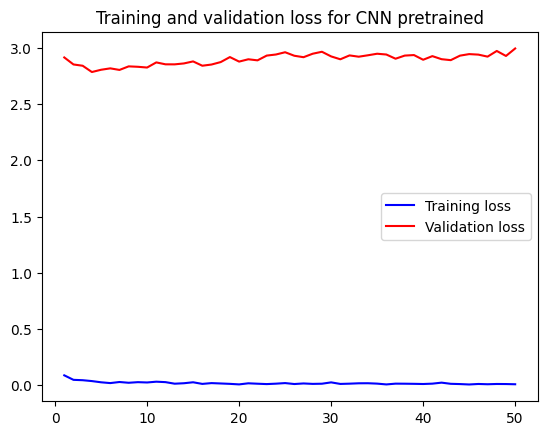

In [ ]:
#getting train and validation accuracies
train_acc_history_pretrained_ft = history_fine_tune.history['accuracy']
val_acc_history_pretrained_ft = history_fine_tune.history['val_accuracy']

#getting train and validation losses
train_loss_history_pretrained_ft = history_fine_tune.history['loss']
val_loss_history_pretrained_ft = history_fine_tune.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_history_pretrained_ft, 'b', label='Training acc')
plt.plot(epochs, val_acc_history_pretrained_ft, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN pretrained')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_history_pretrained_ft, 'b', label='Training loss')
plt.plot(epochs, val_loss_history_pretrained_ft, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN pretrained')
plt.legend()

plt.show()

**3. Create a tf.data.Dataset from images in your test set.** Evaluate the performance of the model on the test data. What is accuracy of the model on the test data?

The test accuracy tells us how our model did on average across all 6 target classes. We want to know how our model did on each individual target class. Let’s get the predicted labels/classes for each image in the test data and compare it to the true labels for each target class. To do this, you can follow these steps:

• use model.predict to get the predicted probabilities for each image in the test data. The predicted probabilities will be an array of shape (number_of_test_images, k) where k is the number of target classes

• Use np.argmax() to get the index of the class with maximum predicted probability for each image. This returns an array of predicted class indices for the images in the test data.

• Now that you have both the predicted class indices and true class indices, you can get a confusion matrix using confusion_matrix method from sklearn library.

• Note that by default “image_dataset_from_directory” method assign label indices to target classes in alphabetical order.

• Take a look at the confusion matrix, which categories your model seems to struggle with the most? Visualize some of the misclassified images in those categories


19/19 [==============================] - 2s 11ms/step


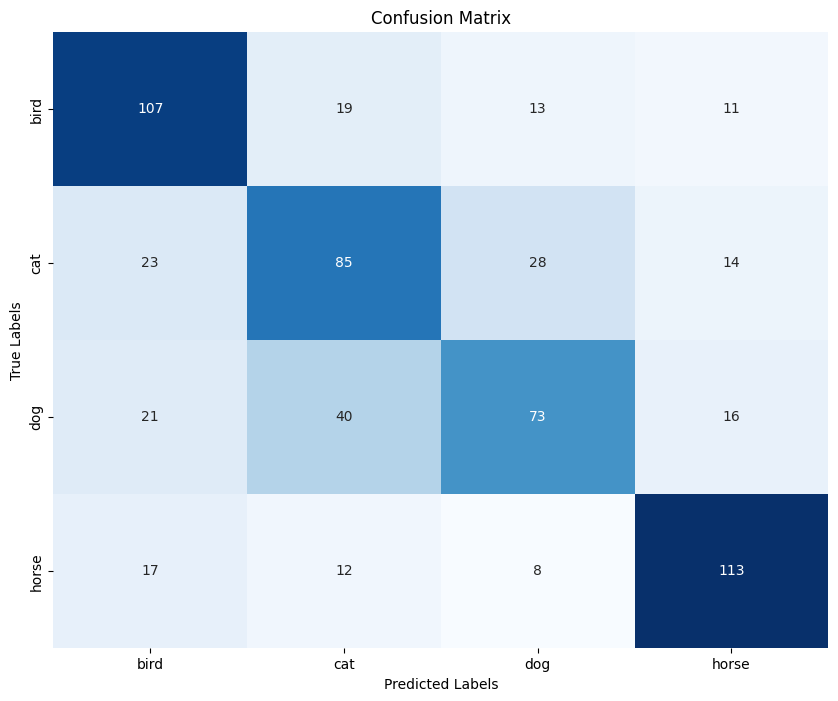

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define your class labels
class_labels = ['bird', 'cat', 'dog', 'horse']

# Get predicted probabilities for each image
predicted_probabilities = pretrained_model.predict(test_dataset)

#print(predicted_probabilities)

# Get predicted class indices for each image
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get true labels from test dataset
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Our model seems to be performing better at predicting horsesa and bird compared to other categories. However, the cat and dog class accuracy appears to be low. Interestingly, a significant number of images classified as cats might actually be dogs.

**Visualize some of the misclassified images in the categories**

1/1 [==============================] - 0s 30ms/step
True label is: horse, CNN predicted cat with confidence 0.9959709048271179


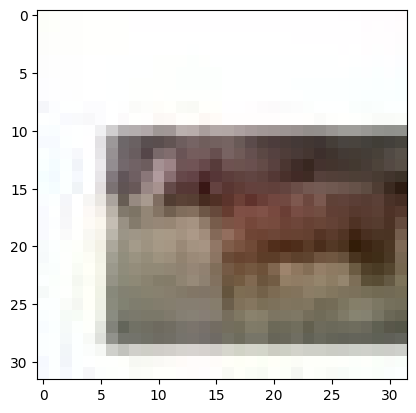

True label is: cat, CNN predicted dog with confidence 0.9294066429138184


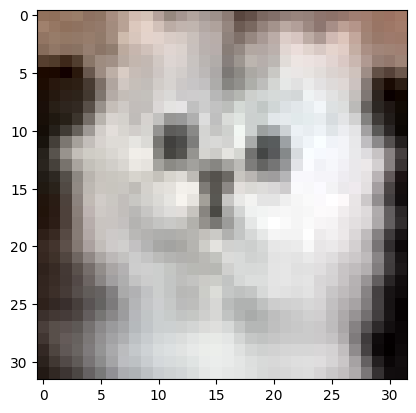

True label is: dog, CNN predicted horse with confidence 0.5088635087013245


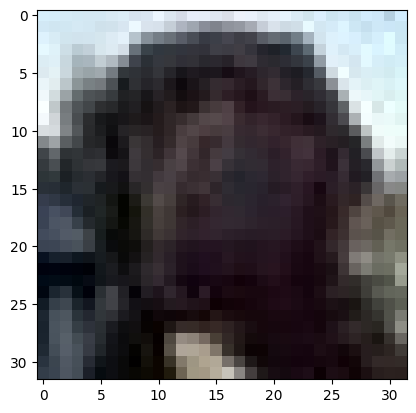

True label is: dog, CNN predicted horse with confidence 0.9276965856552124


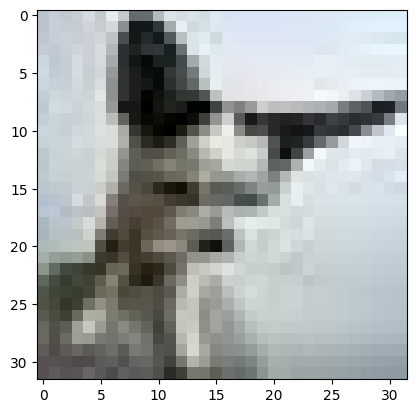

True label is: bird, CNN predicted dog with confidence 0.9635534882545471


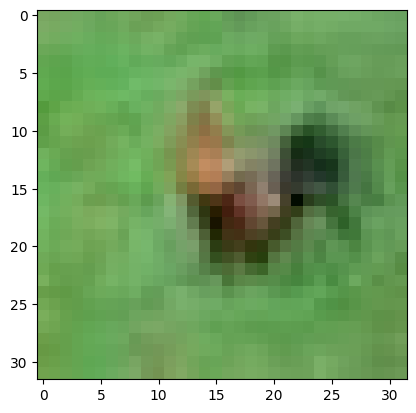

True label is: dog, CNN predicted cat with confidence 0.9404592514038086


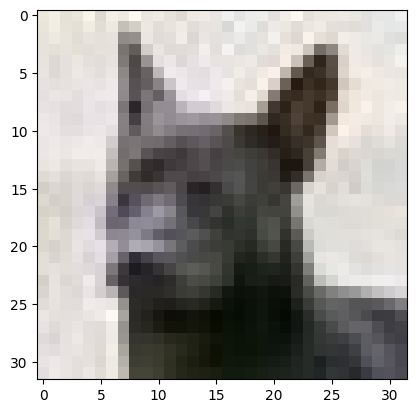

True label is: cat, CNN predicted bird with confidence 0.6104315519332886


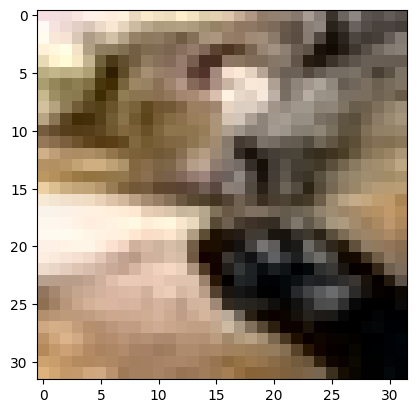

True label is: bird, CNN predicted horse with confidence 0.9999632835388184


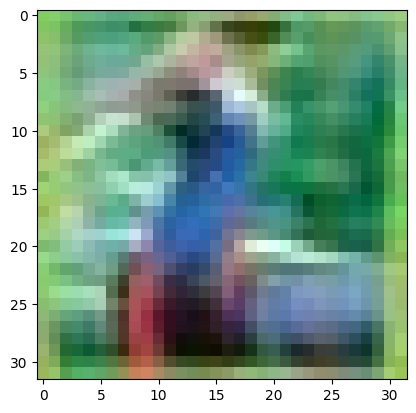

True label is: dog, CNN predicted cat with confidence 0.8736270666122437


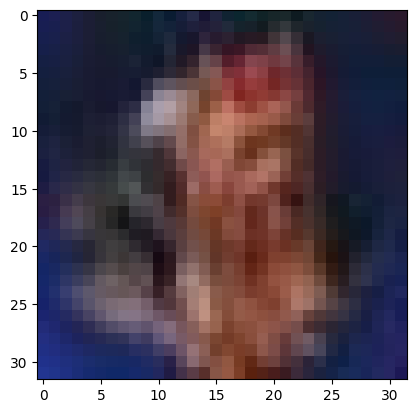

True label is: horse, CNN predicted dog with confidence 0.9176722168922424


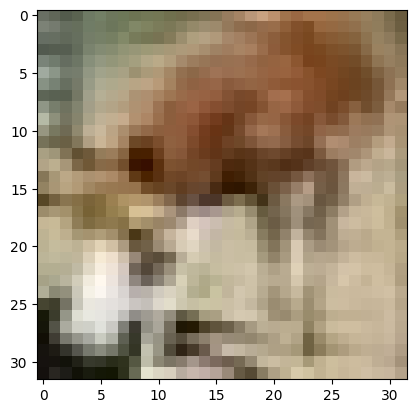

True label is: cat, CNN predicted dog with confidence 0.8164495825767517


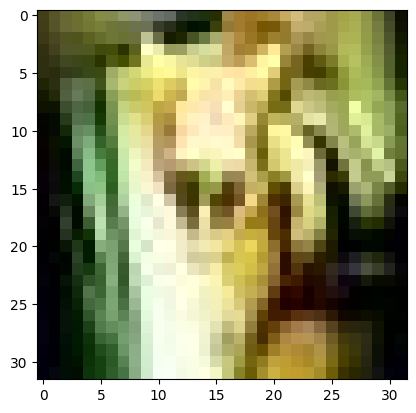

1/1 [==============================] - 0s 30ms/step
True label is: dog, CNN predicted cat with confidence 0.7730186581611633


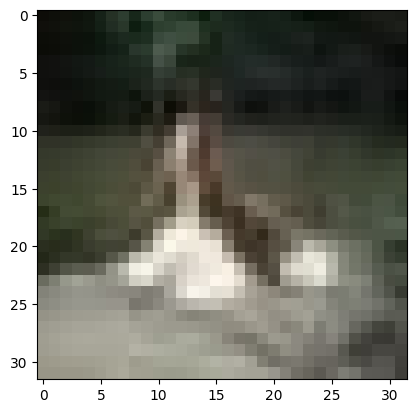

True label is: dog, CNN predicted cat with confidence 0.9969653487205505


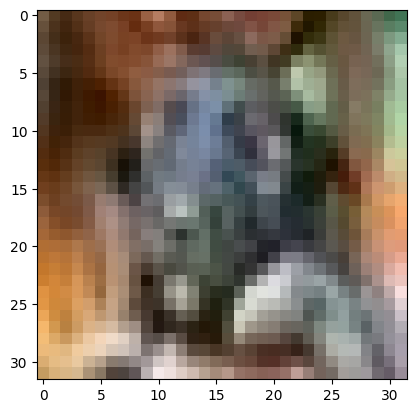

True label is: cat, CNN predicted dog with confidence 0.9899236559867859


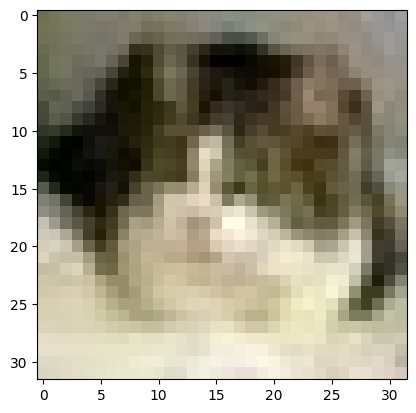

True label is: bird, CNN predicted cat with confidence 0.7646839618682861


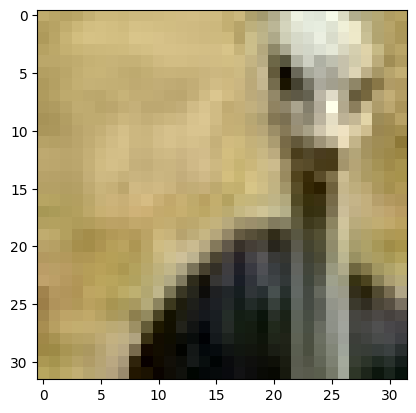

True label is: cat, CNN predicted horse with confidence 0.9988811612129211


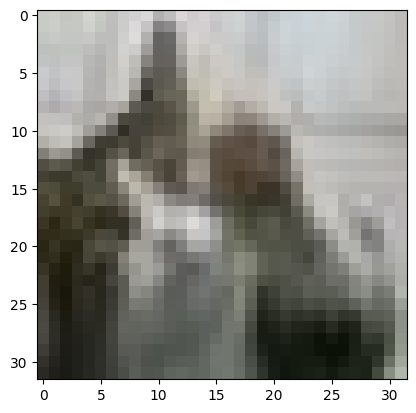

True label is: dog, CNN predicted cat with confidence 0.4932503402233124


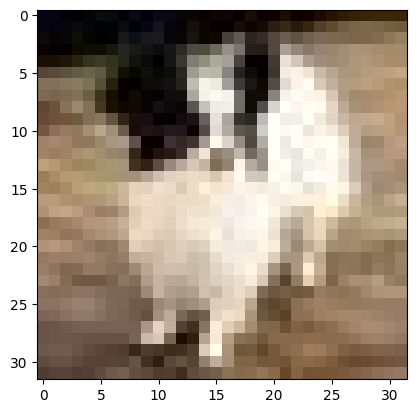

True label is: cat, CNN predicted bird with confidence 0.5408945679664612


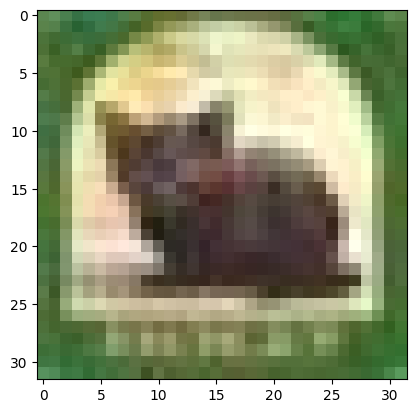

1/1 [==============================] - 0s 27ms/step
True label is: cat, CNN predicted dog with confidence 0.5138417482376099


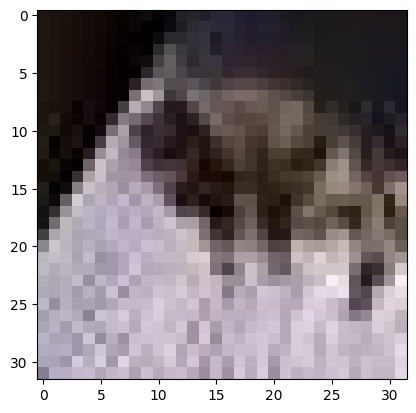

True label is: cat, CNN predicted dog with confidence 0.7003834843635559


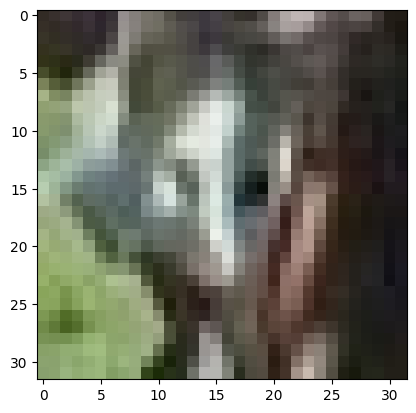

True label is: bird, CNN predicted dog with confidence 0.8622760772705078


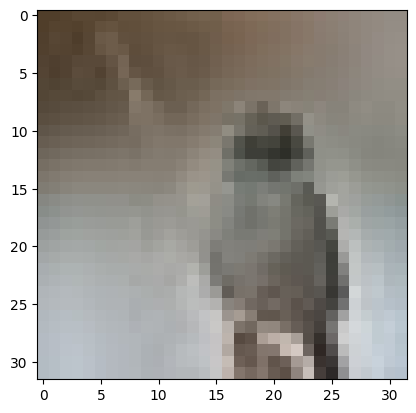

True label is: dog, CNN predicted horse with confidence 0.6629368662834167


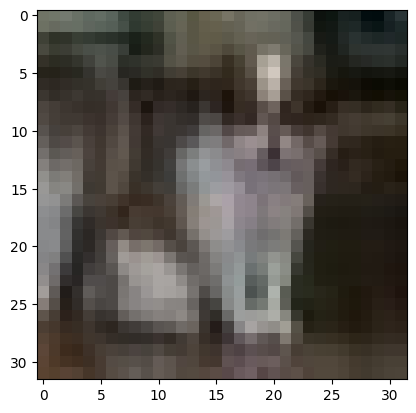

True label is: dog, CNN predicted horse with confidence 0.4249671697616577


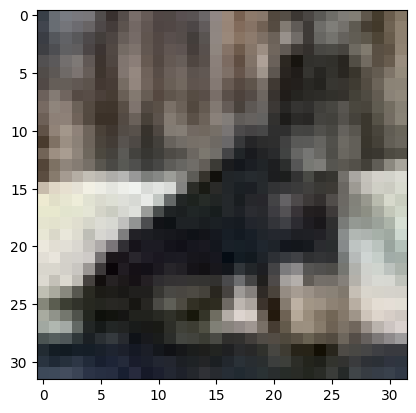

True label is: bird, CNN predicted cat with confidence 0.999818742275238


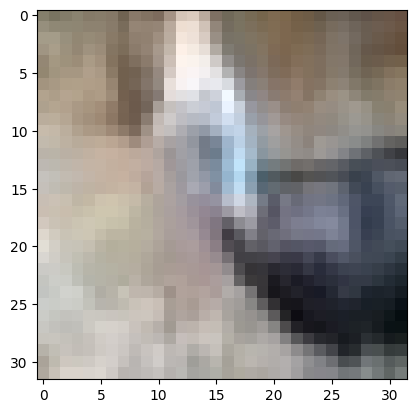

True label is: dog, CNN predicted horse with confidence 0.9789456725120544


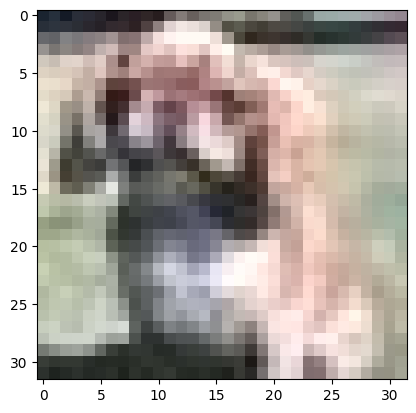

True label is: horse, CNN predicted dog with confidence 0.9891519546508789


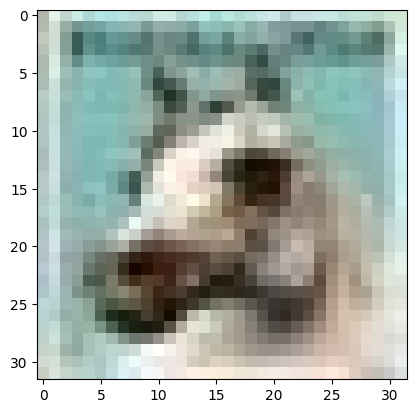

True label is: horse, CNN predicted bird with confidence 0.9745050668716431


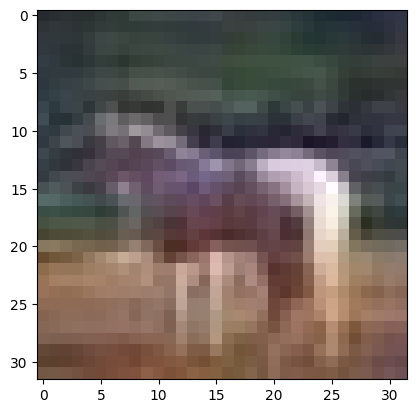

1/1 [==============================] - 0s 28ms/step
True label is: bird, CNN predicted dog with confidence 0.7847678661346436


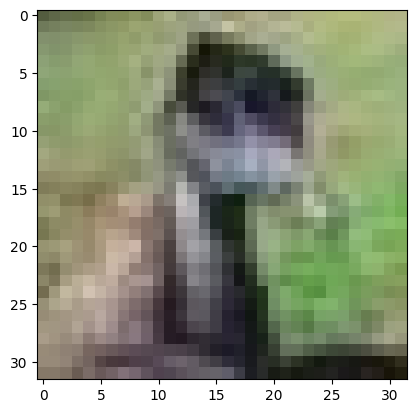

True label is: dog, CNN predicted cat with confidence 0.983102023601532


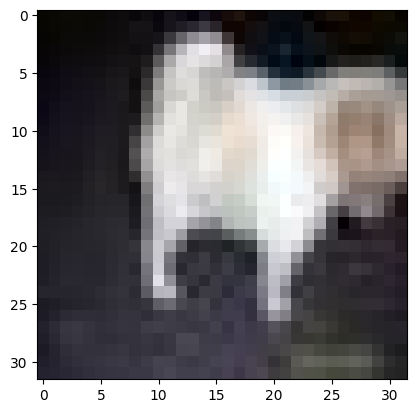

True label is: dog, CNN predicted cat with confidence 0.6785942316055298


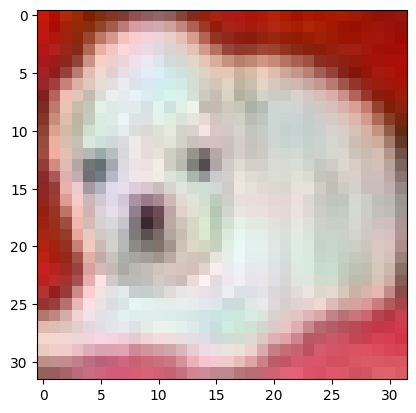

True label is: cat, CNN predicted bird with confidence 0.7476291656494141


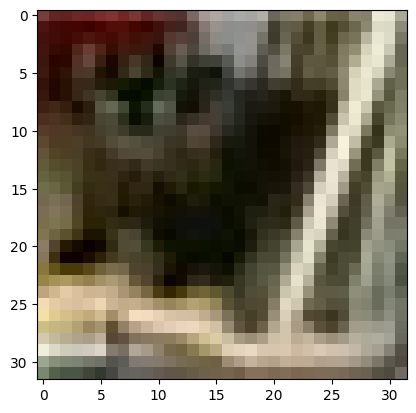

True label is: horse, CNN predicted cat with confidence 0.615231454372406


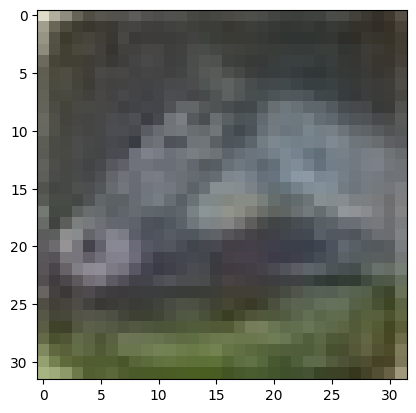

True label is: horse, CNN predicted bird with confidence 0.9122903943061829


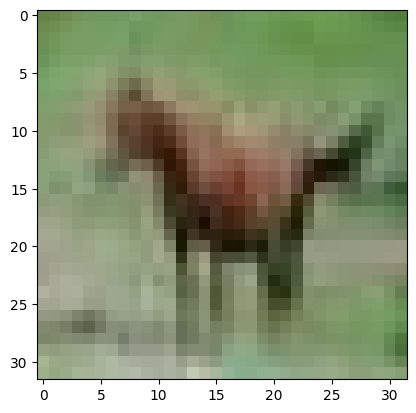

True label is: dog, CNN predicted cat with confidence 0.8834555149078369


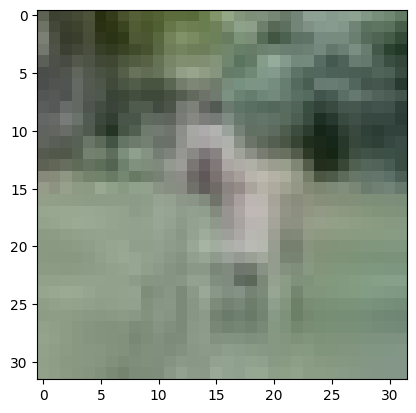

True label is: cat, CNN predicted horse with confidence 0.29087701439857483


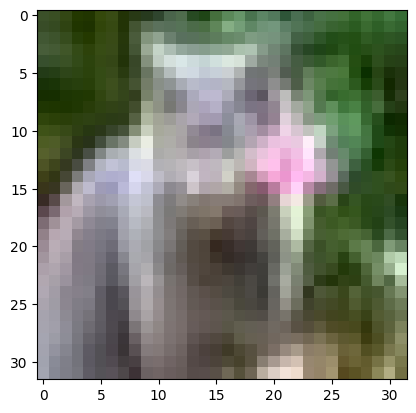

True label is: horse, CNN predicted cat with confidence 0.9652872681617737


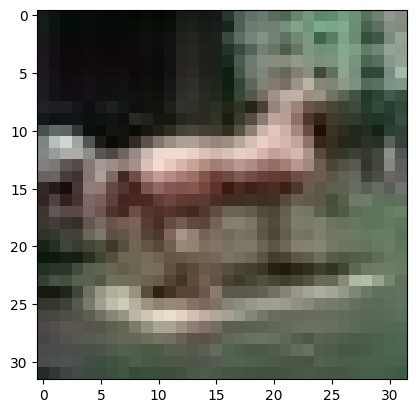

True label is: horse, CNN predicted bird with confidence 0.8733651638031006


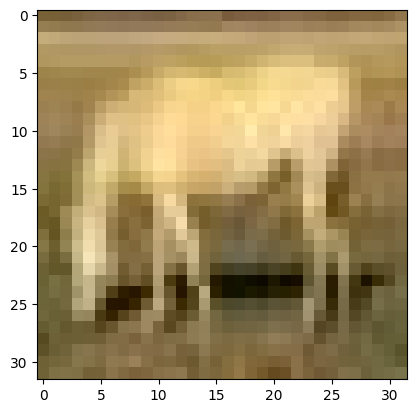

True label is: dog, CNN predicted cat with confidence 0.9585960507392883


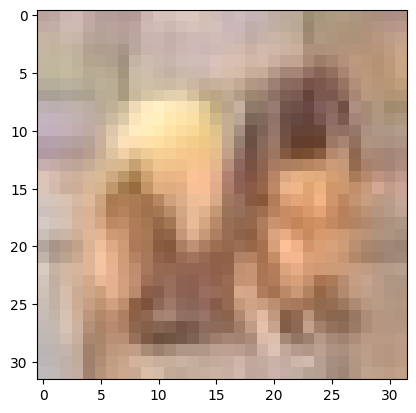

True label is: cat, CNN predicted horse with confidence 0.9960000514984131


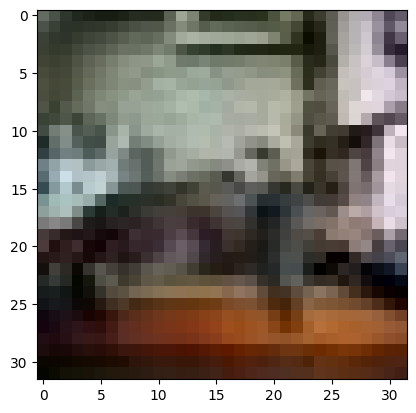

True label is: bird, CNN predicted horse with confidence 0.6358221769332886


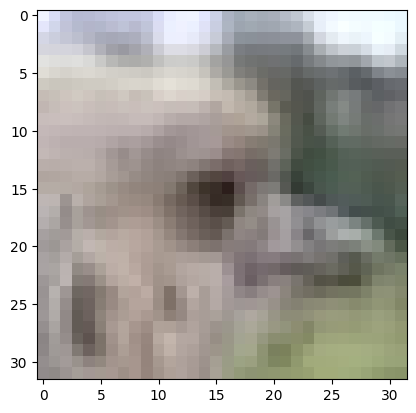

True label is: cat, CNN predicted dog with confidence 0.8424063920974731


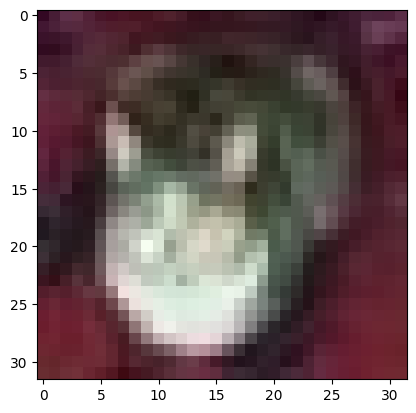

1/1 [==============================] - 0s 28ms/step
True label is: dog, CNN predicted bird with confidence 0.9101626873016357


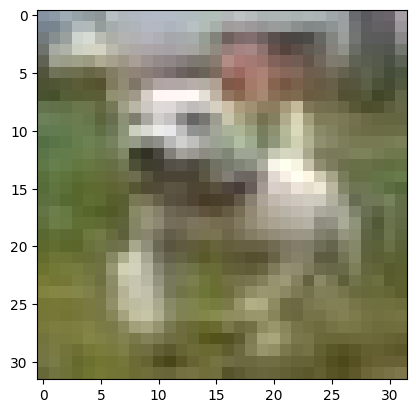

True label is: bird, CNN predicted horse with confidence 0.6659623384475708


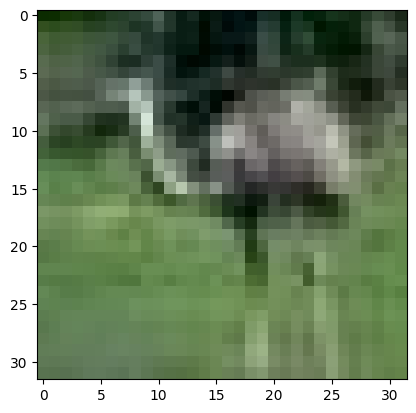

True label is: bird, CNN predicted cat with confidence 0.6095910668373108


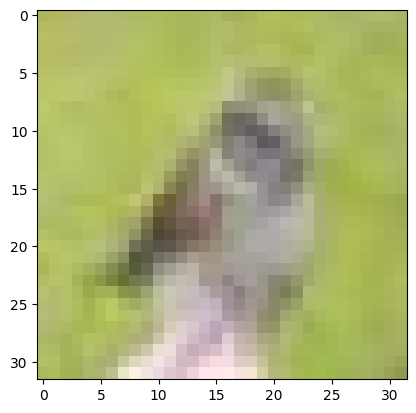

True label is: cat, CNN predicted bird with confidence 0.9869297742843628


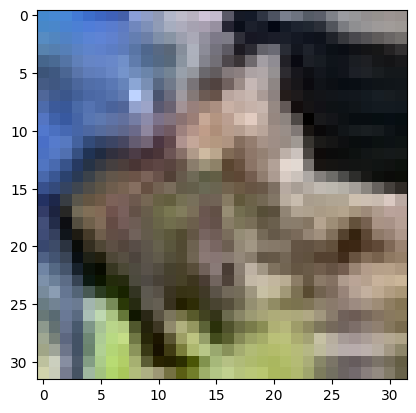

True label is: cat, CNN predicted horse with confidence 0.9693151116371155


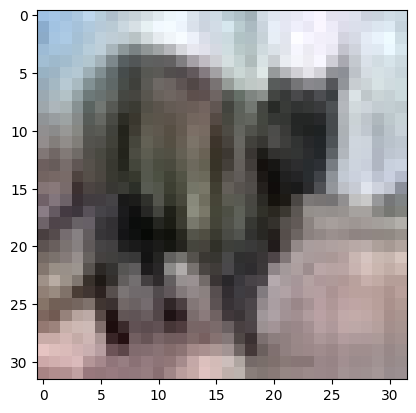

True label is: cat, CNN predicted horse with confidence 0.9964787364006042


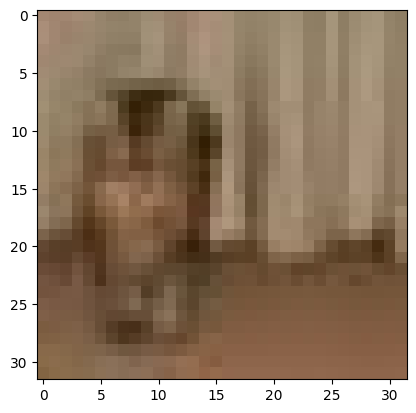

True label is: horse, CNN predicted bird with confidence 0.9996218681335449


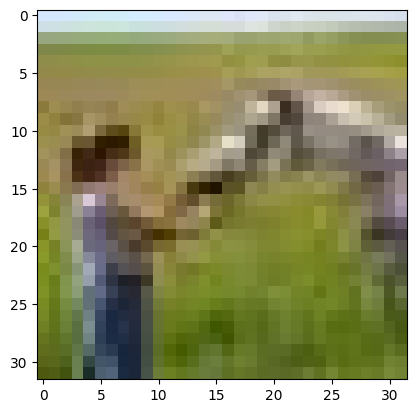

True label is: bird, CNN predicted cat with confidence 0.8955733180046082


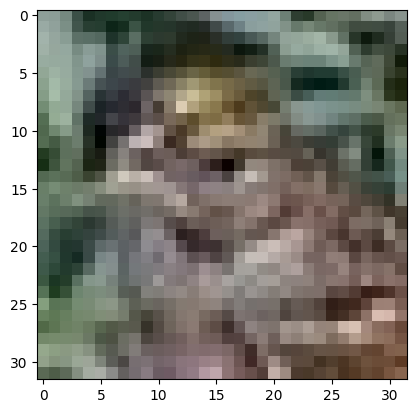

True label is: bird, CNN predicted horse with confidence 0.5509436726570129


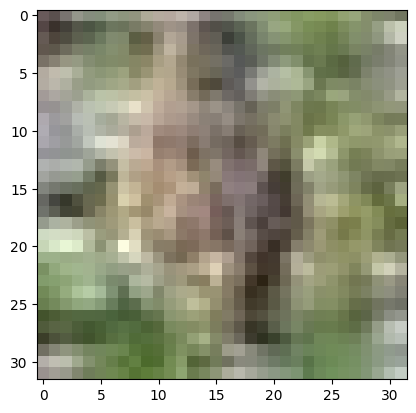

True label is: horse, CNN predicted dog with confidence 0.6985491514205933


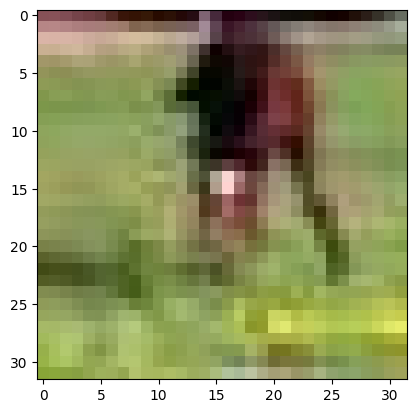

True label is: horse, CNN predicted dog with confidence 0.9500247240066528


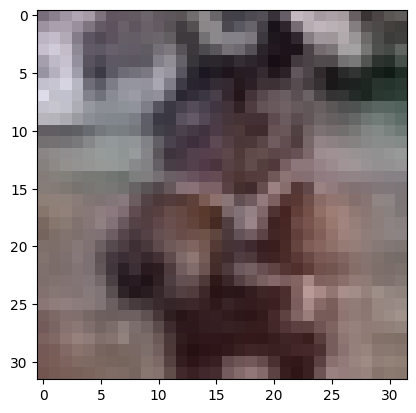

True label is: bird, CNN predicted dog with confidence 0.5143128633499146


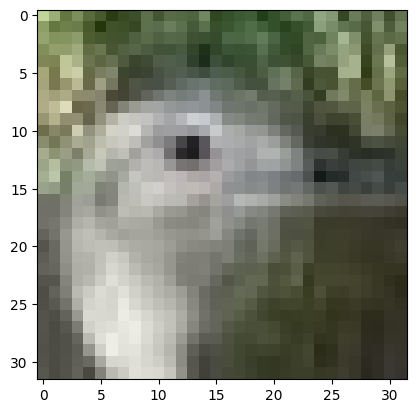

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Dictionary for label names
names = {0: "bird", 1: "cat", 2: "dog", 3: "horse"}

# Parameters
batch_size = 32
validation_size = 150
batch_index = 0

# Loop through each batch of images and labels in the validation dataset
for image_batch, label_batch in validation_dataset:
    if batch_index >= math.ceil(validation_size / batch_size):
        break

    # Get the predicted probabilities for the images in the batch
    y_pred = pretrained_model.predict(image_batch)

    # Convert predicted probabilities to predicted labels (0, 1, 2, 3)
    y_pred_label = np.argmax(y_pred, axis=-1)

    # Get the indices of the misclassified images in the batch
    errors = np.where(y_pred_label != label_batch.numpy())[0]

    # Display the misclassified images together with their predicted probabilities
    for i in errors:
        # True label and predicted label
        true_label = names[label_batch[i].numpy()]
        predicted_label = names[y_pred_label[i]]

        # Confidence
        confidence = y_pred[i][y_pred_label[i]]

        # Print details and show image
        print(f"True label is: {true_label}, CNN predicted {predicted_label} with confidence {confidence}")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.show()

    # Get the next batch
    batch_index += 1


**4.** If model has low accuracy on some of the categories, go back to question 1 and collect more data and increase diversity of images in dataset.

We are going to use the entire dataset so there will be diversity of the images.

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Specify the directory where we store smaller data
base_dir = 'cifar10_fullset'

# Delete the directory if already exists
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

# Create subdirectories for train/test/validation under the base directory
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Categories to use from CIFAR-10
categories = ['bird', 'cat', 'dog', 'horse']

# Define the number of images per category for train, validation, and test
num_train_per_category = 1400
num_val_per_category = 300
num_test_per_category = 300

# Define the actual class labels for CIFAR-10
cifar_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

for category in categories:
    # Create subdirectories for each category under train/validation/test directory
    train_category_dir = os.path.join(train_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    validation_category_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_category_dir, exist_ok=True)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(test_category_dir, exist_ok=True)

    # Indices of images in the current category (using the correct label index)
    indices = [i for i, label in enumerate(y_train) if label == cifar_class_names.index(category)]

    # Shuffle indices to randomize image selection
    import random
    random.shuffle(indices)

    # Select images for train, validation, and test
    train_indices = indices[:num_train_per_category]
    val_indices = indices[num_train_per_category:num_train_per_category + num_val_per_category]
    test_indices = indices[num_train_per_category + num_val_per_category:num_train_per_category + num_val_per_category + num_test_per_category]

    # Copy images to appropriate directories
    for idx_list, dest_dir in [(train_indices, train_category_dir),
                               (val_indices, validation_category_dir),
                               (test_indices, test_category_dir)]:
        for i, idx in enumerate(idx_list):
            img = x_train[idx]
            dst = os.path.join(dest_dir, f'{category}_{i}.jpg')

            # Convert to PIL Image and save
            img_pil = Image.fromarray(img)
            img_pil.save(dst)

# Print total number of images for each category and set
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    validation_category_dir = os.path.join(validation_dir, category)
    test_category_dir = os.path.join(test_dir, category)

    print(f'Total training {category} images:', len(os.listdir(train_category_dir)))
    print(f'Total validation {category} images:', len(os.listdir(validation_category_dir)))
    print(f'Total test {category} images:', len(os.listdir(test_category_dir)))

Total training bird images: 1400
Total validation bird images: 300
Total test bird images: 300
Total training cat images: 1400
Total validation cat images: 300
Total test cat images: 300
Total training dog images: 1400
Total validation dog images: 300
Total test dog images: 300
Total training horse images: 1400
Total validation horse images: 300
Total test horse images: 300


In [ ]:
# Define image size and batch size
image_size = (32, 32)
batch_size = 32

# Create train dataset
train_dataset_2 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# Create validation dataset
validation_dataset_2 = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

# Create test dataset
test_dataset_2 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

Found 5600 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.


In [ ]:
#compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
pretrained_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=opt)


history_fine_tune = pretrained_model.fit(
            train_dataset_2,
            validation_data = validation_dataset_2,
            epochs = 50,
            verbose = 1
            )

Epoch 1/50
175/175 [==============================] - 12s 27ms/step - loss: 2.9149 - accuracy: 0.6670 - val_loss: 2.6455 - val_accuracy: 0.6858
Epoch 2/50
175/175 [==============================] - 3s 16ms/step - loss: 2.7868 - accuracy: 0.6704 - val_loss: 2.5966 - val_accuracy: 0.6875
Epoch 3/50
175/175 [==============================] - 3s 16ms/step - loss: 2.6907 - accuracy: 0.6714 - val_loss: 2.5454 - val_accuracy: 0.6867
Epoch 4/50
175/175 [==============================] - 3s 16ms/step - loss: 2.6445 - accuracy: 0.6754 - val_loss: 2.4822 - val_accuracy: 0.6867
Epoch 5/50
175/175 [==============================] - 3s 16ms/step - loss: 2.5521 - accuracy: 0.6848 - val_loss: 2.4354 - val_accuracy: 0.6883
Epoch 6/50
175/175 [==============================] - 3s 16ms/step - loss: 2.4814 - accuracy: 0.6829 - val_loss: 2.3886 - val_accuracy: 0.6883
Epoch 7/50
175/175 [==============================] - 3s 16ms/step - loss: 2.4589 - accuracy: 0.6773 - val_loss: 2.3355 - val_accuracy: 0.688

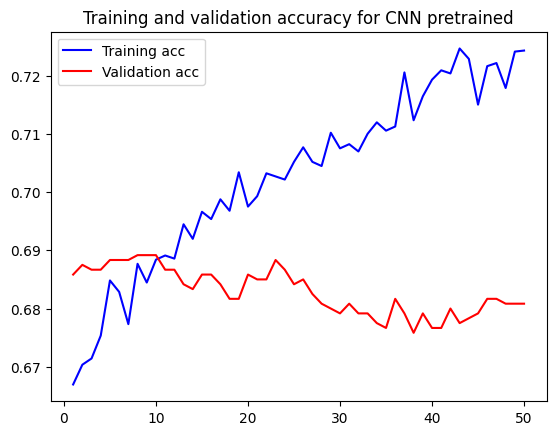

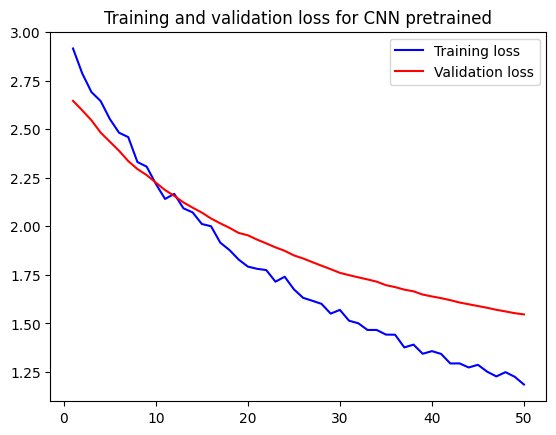

In [ ]:
#getting train and validation accuracies
train_acc_ft = history_fine_tune.history['accuracy']
val_acc_ft = history_fine_tune.history['val_accuracy']

#getting train and validation losses
train_loss_ft = history_fine_tune.history['loss']
val_loss_ft = history_fine_tune.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_ft, 'b', label='Training acc')
plt.plot(epochs, val_acc_ft, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN pretrained')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_ft, 'b', label='Training loss')
plt.plot(epochs, val_loss_ft, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN pretrained')
plt.legend()

plt.show()

The model's performance has improved, with training accuracy increasing from 60% to 70%. However, the learning curves reveal a gap between the training and validation loss. This suggests potential overfitting, where the model might be memorizing the training data instead of generalizing well to unseen data. While validation accuracy has remained between 60% and 70%.